In [17]:
import torch
import kagglehub
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import os
import numpy as np
import torch
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image
import matplotlib.pyplot as plt
import torchvision.models as models

In [18]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu') #define que meu modelo rodarÃ¡ na minha GPU

In [19]:
path = kagglehub.dataset_download("misrakahmed/vegetable-image-dataset")    #define o caminho onde os arquivos do dataset estao baixados

In [20]:
treino_pasta = os.path.join(path, "Vegetable Images", "train")  #caminho da pasta TRAIN
validacao_pasta = os.path.join(path, "Vegetable Images", "validation")  #caminho da pasta VALIDATION
teste_pasta = os.path.join(path, "Vegetable Images", "test")    #caminho da pasta TEST

In [21]:
transform_treino = transforms.Compose([                                 #faz Data Augmentation para os dados de treino fazendo crops de tamanhos aleatÃ³rios na imagem, flips horizontais, rotacoes ewm diferentes angulos
    transforms.RandomResizedCrop(size=(224, 224), antialias=True),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [22]:
transform_validacao_teste = transforms.Compose([       #faz apenas o redimensionamento (neste caso nao muda nada pois a imagem ja eh 224x224)
    transforms.Resize((224, 224)),                  #esta funcao so existe pois eh necessario passar os dados de VALIDACAO e TESTE por um transform 
    transforms.ToTensor(),                          #e por serem VALIDDACAO e TESTE eles nao podem ser alterados!! Por isso o REDIMENSIONAMENTO REDUNDANTE
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [23]:
dados_treino = ImageFolder(root=treino_pasta, transform=transform_treino)   #cria pastas para facilitar a manipulacao dos dados (tipo usar .classes pra achar as classes)
dados_validacao = ImageFolder(root=validacao_pasta, transform=transform_validacao_teste)
dados_teste = ImageFolder(root=teste_pasta, transform=transform_validacao_teste)

In [24]:
train_loader = DataLoader(dados_treino, batch_size=32, shuffle=True)    #carrega os dados de treino em batches de 32 imagens, EMBARALHA os dados a cada EPOCA
val_loader = DataLoader(dados_validacao, batch_size=32, shuffle=False)  #carrega os dados de treino em batches de 32 imagens, FIXA os dados
test_loader = DataLoader(dados_teste, batch_size=32, shuffle=False)     #carrega os dados de treino em batches de 32 imagens, FIXA os dados

In [25]:
tamanho_das_imagens = 224   #tamanho das imagens do Dataset
tamanho_do_kernel = 3 #tamanho do Kernel escolhido pois 5x5 ou 7x7 aumentam muito o numero de parametros 
stride = 1  #tanto Stride = 1 e Padding = 1 foram escolhidos para garantir que nao tenha perca de detalhes da imagem
padding = 1  
tamanho_do_max_pooling = 2  #max pooling 2x2
learning_rate = 0.0005

In [26]:
def CNN():
    class classifica_vegetais(nn.Module):
        def __init__(self):
            super().__init__()
            self.conv1 = nn.Conv2d(3, 64, tamanho_do_kernel, stride, padding)     #PRIMERIA camada de convoluÃ§Ã£o, recebendo 3 entradas (RGB) e resulta em 64 feature_maps
 
            self.conv2 = nn.Conv2d(64, 128, tamanho_do_kernel, stride, padding)   #SEGUNDA camada de convoluÃ§Ã£o, recebendo 3 entradas (RGB) e resulta em 128 feature_maps
            self.conv3 = nn.Conv2d(128, 256, tamanho_do_kernel, stride, padding)  #TRECEIRA camada de convoluÃ§Ã£o, recebendo 3 entradas (RGB) e resulta em 256 feature_maps
            self.conv4 = nn.Conv2d(256, 512, tamanho_do_kernel, stride, padding)  #QUARTA camada de convoluÃ§Ã£o, recebendo 3 entradas (RGB) e resulta em 512 feature_maps
            self.conv5 = nn.Conv2d(512, 512, tamanho_do_kernel, stride, padding) #QUINTA camada de convoluÃ§Ã£o, recebendo 3 entradas (RGB) e resulta em 1024 feature_maps

            #self.conv6 = nn.Conv2d(1024, 1024, tamanho_do_kernel, stride, padding)#SEXTA camada de convoluÃ§Ã£o, recebendo 3 entradas (RGB) e resulta em 1024 feature_maps
                                                                            #entre 1024 e sai 1024 porem a convoluÃ§Ã£o ainda Ã© feita, gerando novos feature_maps
                                                                            #servindo para aumentar ainda mais a profundidade da rede    
            
            self.fc1 = nn.Linear(512 * 7 * 7, 512)    #PRIMEIRA camada FULLY CONNECTED, recebendo 1024 * 3 * 3 = 9216 e reduzindo para 1024
                                                        #ele Ã© * 3 * 3 pois sÃ£o 6 camadas e vamos dividindo a partir de 224 (tamanho da imagem)
                                                        #224/2=112 ; 112/2=56 ; 56/2=28 ; 28/2=14 ; 14/2=7 ; 7/2=3.5 (arredondei pra baixo, portanto 3)
            self.output = nn.Linear(512, 15)   #camada FINAL recebendo 1024 e resultando em apenas 15 (numero de classes)  
        def forward(self, x):
            x = F.relu(self.conv1(x))   #PRIMEIRA convoluÃ§Ã£o e RELU
            x = F.max_pool2d(x, tamanho_do_max_pooling) #PRIMEIRO max pooling
            x = F.relu(self.conv2(x))   #SEGUNDA convoluÃ§Ã£o e RELU
            x = F.max_pool2d(x, tamanho_do_max_pooling) #SEGUNDA max pooling
            x = F.relu(self.conv3(x))   #TERCEIRA convoluÃ§Ã£o e RELU
            x = F.max_pool2d(x, tamanho_do_max_pooling) #TERCEIRA max pooling
      
            x = F.relu(self.conv4(x))   #QUARTA convoluÃ§Ã£o e RELU
            x = F.max_pool2d(x, tamanho_do_max_pooling) #QUARTA max pooling
            
            x = F.relu(self.conv5(x))   #QUINTA convoluÃ§Ã£o e RELU
            x = F.max_pool2d(x, tamanho_do_max_pooling) #QUINTA max pooling

            #x = F.relu(self.conv6(x))   #SEXTA convoluÃ§Ã£o e RELU
            #x = F.max_pool2d(x, tamanho_do_max_pooling) #SEXTA max pooling
            
            x = torch.flatten(x, 1) #transforma o vetor MULTIDIMENSIONAL em um vetor UNIDIMENSIONAL para utilizar nas FCs (FULLY CONNECTED)
            
            x = F.relu(self.fc1(x)) #PRIMEIRA camada FULLY CONNECTED e RELU
            x = self.output(x)  #retorna 15 LOGITS
            
            return x
    modelo = classifica_vegetais()  #INICIA o modelo
    funcao_loss = nn.CrossEntropyLoss() #define FUNCAO DE LOSS (softmax estÃ¡ dentro da CrossEntropyLoss() ) 
    otimizador = torch.optim.Adam(modelo.parameters(), lr=learning_rate)    #define o otimzador que sera utilizado o Learning Rate de cada parametro
    return modelo, funcao_loss, otimizador

In [27]:
def metodo_treino_modelo():
    numero_de_epocas = 5    #escolho quantas epocas treinar o meu modelo
    modelo, funcao_loss, otimizador = CNN() 
    modelo.to(device)   #coloca para meu modelo rodar na minha GPU
    loss_treino = []    #inicia as listas necessarias para guardas os valores necessarios
    acuracia_treino = []
    f1_score_por_epoca = []
    loss_validacao = []
    acuracia_validacao = []
    loss_teste  = []
    acuracia_teste = []
    
    for epocas in range(numero_de_epocas):
        modelo.train()  #comeca o treinamento do modelo, ativando batchnorm; dropout e etc
        batch_loss_treino = []  #inicializa as listas pra guardar os dados dos batches
        batch_acuracia_treino = []
        treino_previsoes_total = []
        treino_labels_corretos = []
        for imagens_transformadas, labels_das_imagens in train_loader:  #do train_loader vai retornar um tensor, no primeiro (que vai pra varavel "imagens_transformadas")
                                                                    #recebe um tensor com o batch de imagens (32 imagens neste caso), portanto: [32, 3, 224, 224] (numero do batch, tamanho do kernel, tamanho da imagem 2 vezes)
                                                                    # no segundo argumento recebe um tensor com um btach de rÃ³tulos CORRETOS das imagens (de 0 a 14 = 15 classes), portanto: tensor([0,1,2,3 ... ate terem 32])
            imagens_transformadas = imagens_transformadas.to(device)    #coloca para rodar as imagens e labels na GPU
            labels_das_imagens = labels_das_imagens.to(device)
            
            logits_do_batch = modelo(imagens_transformadas) #passa o batch de imagens transformadas pela rede e recebe os logits 
            loss_do_batch = funcao_loss(logits_do_batch, labels_das_imagens)    #compara os logits com os labels corretos e retorna a loss
            
            otimizador.zero_grad()  #zera gradientes antigos
            loss_do_batch.backward() #faz backpropagation e calcula o gradiente da loss (neste caso da variavel "loss_do_batch")
            otimizador.step()   #ajusta os parametros da rede usando os gradientes 
            batch_loss_treino.append(loss_do_batch.item())  #salva o loss da batch para no final calcular a media da loss
            
            previsao_do_modelo = torch.argmax(logits_do_batch, axis=1)  #pega onde esta na lista o MAIOR valor em cada LINHA (axis = 1)
            treino_previsoes_total.append(previsao_do_modelo)   #guarda 1 tensor POR BATCH na lista "treino_previsoes_total"
            treino_labels_corretos.append(labels_das_imagens)   #guarda 1 tensor POR BATCH na lista "treino_labels_corretos"
            acertos = (previsao_do_modelo == labels_das_imagens).sum().item() #conto o numero de acertos
            total = labels_das_imagens.size(0)  #conto o total de labels presentes 
            batch_acuracia_treino.append(acertos / total)   #divido os acertos pelo total
             
        treino_previsoes_total = torch.cat(treino_previsoes_total)  #junta TODOS os tensores da lista "treino_previsoes_total" em UM GRANDE TENSOR
        treino_labels_corretos = torch.cat(treino_labels_corretos)  #junta TODOS os tensores da lista "treino_labels_corretos" em UM GRANDE TENSOR
        f1_score_resultado_treino = f1_score(treino_previsoes_total, treino_labels_corretos, numero_de_classes = 15)    
        f1_score_por_epoca.append(f1_score_resultado_treino)    #concatena na lista "f1_score_por_epoca" o resultado
        loss_treino.append(np.mean(batch_loss_treino))  #calcula a media da loss e guarda
        acuracia_treino.append(100 * np.mean(batch_acuracia_treino))  #o resultado guardado em "batch_acuracia_treino" eh decimal, portanto vc pega a media de todos os batches
                                                                        #e por final pega a porcentagem
        modelo.eval()   #inicio o modo de avaliacao evitando dropouts
        
        with torch.no_grad():   #fazendo isso desligamos CALCULO DE GRADIENTE pois em TESTES e VALIDACAO NAO QUERO CALCULAR GRADIENTE
                                #fazendo isso ganhou MUITO tempo na hora de rodar, portanto foi necessario fazer isso para ganhar tempo
                                #e diminuit o gasto computacional no treinamento
            batch_loss_validacao = [] #inicializa as listas pra guardar os dados dos batches
            batch_acuracia_validacao = []
            
            for imagens_nao_transformadas, labels_das_imagens in val_loader:    #do train_loader vai retornar um tensor, no primeiro (que vai pra varavel "imagens_transformadas")
                                                                    #recebe um tensor com o batch de imagens (32 imagens neste caso), portanto: [32, 3, 224, 224] (numero do batch, tamanho do kernel, tamanho da imagem 2 vezes)
                                                                    # no segundo argumento recebe um tensor com um btach de rÃ³tulos CORRETOS das imagens (de 0 a 14 = 15 classes), portanto: tensor([0,1,2,3 ... ate terem 32])
                imagens_nao_transformadas = imagens_nao_transformadas.to(device)    #coloca para rodar as imagens e labels na GPU    
                labels_das_imagens = labels_das_imagens.to(device)          
                
                logits_do_batch = modelo(imagens_nao_transformadas) #passa o batch de imagens transformadas pela rede e recebe os logits 
                loss_do_batch = funcao_loss(logits_do_batch, labels_das_imagens)    #compara os logits com os labels corretos e retorna a loss
                #PULA A FASE DE OTIMIZACAO, CALCULO DE GRADIENTE E BACKPROPAGATION QUE HAVIA QUANDO TINHA GRADIENTE!!!!!
                
                batch_loss_validacao.append(loss_do_batch.item()) #salva o loss da batch para no final calcular a media da loss
                previsao_do_modelo = torch.argmax(logits_do_batch, axis=1)  #pega onde esta na lista o MAIOR valor em cada LINHA (axis = 1)
                acertos = (previsao_do_modelo == labels_das_imagens).sum().item() #conto o numero de acertos
                total = labels_das_imagens.size(0)  #conto o total de labels presentes 
                batch_acuracia_validacao.append(acertos / total)   #divido os acertos pelo total 
            
            loss_validacao.append(np.mean(batch_loss_validacao))    #calcula a media da loss e guarda
            acuracia_validacao.append(100 * np.mean(batch_acuracia_validacao))  #o resultado guardado em "batch_acuracia_treino" eh decimal, portanto vc pega a media de todos os batches
                                                                                #e por final pega a porcentagem
            
            
            batch_loss_teste = []                                                        #FAZ EXATAMENTE AS MESMAS COISAS QUE NA VALIDACAO!!!!!
            batch_acuracia_teste = []
            for imagens_nao_transformadas, labels_das_imagens in test_loader:
                imagens_nao_transformadas = imagens_nao_transformadas.to(device)
                labels_das_imagens = labels_das_imagens.to(device)
                logits_do_batch = modelo(imagens_nao_transformadas)
                loss_do_batch = funcao_loss(logits_do_batch, labels_das_imagens)
                
                batch_loss_teste.append(loss_do_batch.item())
                previsao_do_modelo = torch.argmax(logits_do_batch, axis=1)  #pega onde esta na lista o MAIOR valor em cada LINHA (axis = 1)
                acertos = (previsao_do_modelo == labels_das_imagens).sum().item() #conto o numero de acertos
                total = labels_das_imagens.size(0)  #conto o total de labels presentes 
                batch_acuracia_teste.append(acertos / total)   #divido os acertos pelo total 
            
            loss_teste.append(np.mean(batch_loss_teste))
            acuracia_teste.append(100 * np.mean(batch_acuracia_teste))
    os.makedirs("modelos", exist_ok=True)
    caminho_modelo = "modelos/modelo_treinado.pth"
    torch.save(modelo.state_dict(), caminho_modelo)
        
    return f1_score_por_epoca, loss_treino, loss_validacao, loss_teste, acuracia_treino, acuracia_validacao, acuracia_teste, modelo

In [28]:
def metodo_treino_modelo_pre_treinado():
    numero_de_epocas = 5    #escolho quantas epocas treinar o meu modelo
    numero_de_classes = 15

    # Para treino
    transform_treino_resnet = transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    # Para validaÃ§Ã£o/teste
    transform_validacao_teste_resnet = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    dados_treino_pre = ImageFolder(root=treino_pasta, transform=transform_treino_resnet)
    dados_validacao_pre = ImageFolder(root=validacao_pasta, transform=transform_validacao_teste_resnet)
    dados_teste_pre = ImageFolder(root=teste_pasta, transform=transform_validacao_teste_resnet)
    train_loader_pre = DataLoader(dados_treino_pre, batch_size=64, shuffle=True)    #carrega os dados de treino em batches de 32 imagens, EMBARALHA os dados a cada EPOCA
    val_loader_pre = DataLoader(dados_validacao_pre, batch_size=64, shuffle=False)  #carrega os dados de treino em batches de 32 imagens, FIXA os dados
    test_loader_pre = DataLoader(dados_teste_pre, batch_size=64, shuffle=False) 
    resnet = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
    resnet.fc = nn.Linear(resnet.fc.in_features, numero_de_classes)
    resnet.to(device)   #coloca para meu modelo rodar na minha GPU
    funcao_loss = nn.CrossEntropyLoss()
    otimizador = torch.optim.Adam(resnet.parameters(), lr=0.0001)

    loss_treino = []    #inicia as listas necessarias para guardas os valores necessarios
    acuracia_treino = []
    f1_score_por_epoca = []
    loss_validacao = []
    acuracia_validacao = []
    loss_teste  = []
    acuracia_teste = []
    
    for epocas in range(numero_de_epocas):
        resnet.train()  #comeca o treinamento do modelo, ativando batchnorm; dropout e etc
        batch_loss_treino = []  #inicializa as listas pra guardar os dados dos batches
        batch_acuracia_treino = []
        treino_previsoes_total = []
        treino_labels_corretos = []
        for imagens_transformadas, labels_das_imagens in train_loader_pre:  #do train_loader vai retornar um tensor, no primeiro (que vai pra varavel "imagens_transformadas")
                                                                    #recebe um tensor com o batch de imagens (32 imagens neste caso), portanto: [32, 3, 224, 224] (numero do batch, tamanho do kernel, tamanho da imagem 2 vezes)
                                                                    # no segundo argumento recebe um tensor com um btach de rÃ³tulos CORRETOS das imagens (de 0 a 14 = 15 classes), portanto: tensor([0,1,2,3 ... ate terem 32])
            imagens_transformadas = imagens_transformadas.to(device)    #coloca para rodar as imagens e labels na GPU
            labels_das_imagens = labels_das_imagens.to(device)
            
            logits_do_batch = resnet(imagens_transformadas) #passa o batch de imagens transformadas pela rede e recebe os logits 
            loss_do_batch = funcao_loss(logits_do_batch, labels_das_imagens)    #compara os logits com os labels corretos e retorna a loss
            
            otimizador.zero_grad()  #zera gradientes antigos
            loss_do_batch.backward() #faz backpropagation e calcula o gradiente da loss (neste caso da variavel "loss_do_batch")
            otimizador.step()   #ajusta os parametros da rede usando os gradientes 
            batch_loss_treino.append(loss_do_batch.item())  #salva o loss da batch para no final calcular a media da loss
            
            previsao_do_modelo = torch.argmax(logits_do_batch, axis=1)  #pega onde esta na lista o MAIOR valor em cada LINHA (axis = 1)
            treino_previsoes_total.append(previsao_do_modelo)   #guarda 1 tensor POR BATCH na lista "treino_previsoes_total"
            treino_labels_corretos.append(labels_das_imagens)   #guarda 1 tensor POR BATCH na lista "treino_labels_corretos"
            acertos = (previsao_do_modelo == labels_das_imagens).sum().item() #conto o numero de acertos
            total = labels_das_imagens.size(0)  #conto o total de labels presentes 
            batch_acuracia_treino.append(acertos / total)   #divido os acertos pelo total
             
        treino_previsoes_total = torch.cat(treino_previsoes_total)  #junta TODOS os tensores da lista "treino_previsoes_total" em UM GRANDE TENSOR
        treino_labels_corretos = torch.cat(treino_labels_corretos)  #junta TODOS os tensores da lista "treino_labels_corretos" em UM GRANDE TENSOR
        f1_score_resultado_treino = f1_score(treino_previsoes_total, treino_labels_corretos, numero_de_classes = 15)    
        f1_score_por_epoca.append(f1_score_resultado_treino)    #concatena na lista "f1_score_por_epoca" o resultado
        loss_treino.append(np.mean(batch_loss_treino))  #calcula a media da loss e guarda
        acuracia_treino.append(100 * np.mean(batch_acuracia_treino))    #o resultado guardado em "batch_acuracia_treino" eh decimal, portanto vc pega a media de todos os batches
                                                                        #e por final pega a porcentagem
        resnet.eval()   #inicio o modo de avaliacao evitando dropouts
        
        with torch.no_grad():   #fazendo isso desligamos CALCULO DE GRADIENTE pois em TESTES e VALIDACAO NAO QUERO CALCULAR GRADIENTE
                                #fazendo isso ganhou MUITO tempo na hora de rodar, portanto foi necessario fazer isso para ganhar tempo
                                #e diminuit o gasto computacional no treinamento
            batch_loss_validacao = [] #inicializa as listas pra guardar os dados dos batches
            batch_acuracia_validacao = []
            
            for imagens_nao_transformadas, labels_das_imagens in val_loader_pre:    #do train_loader vai retornar um tensor, no primeiro (que vai pra varavel "imagens_transformadas")
                                                                    #recebe um tensor com o batch de imagens (32 imagens neste caso), portanto: [32, 3, 224, 224] (numero do batch, tamanho do kernel, tamanho da imagem 2 vezes)
                                                                    # no segundo argumento recebe um tensor com um btach de rÃ³tulos CORRETOS das imagens (de 0 a 14 = 15 classes), portanto: tensor([0,1,2,3 ... ate terem 32])

                imagens_nao_transformadas = imagens_nao_transformadas.to(device)    #coloca para rodar as imagens e labels na GPU    
                labels_das_imagens = labels_das_imagens.to(device)          
                
                logits_do_batch = resnet(imagens_nao_transformadas) #passa o batch de imagens transformadas pela rede e recebe os logits 
                loss_do_batch = funcao_loss(logits_do_batch, labels_das_imagens)    #compara os logits com os labels corretos e retorna a loss
                #PULA A FASE DE OTIMIZACAO, CALCULO DE GRADIENTE E BACKPROPAGATION QUE HAVIA QUANDO TINHA GRADIENTE!!!!!
                
                batch_loss_validacao.append(loss_do_batch.item()) #salva o loss da batch para no final calcular a media da loss
                previsao_do_modelo = torch.argmax(logits_do_batch, axis=1)  #pega onde esta na lista o MAIOR valor em cada LINHA (axis = 1)
                acertos = (previsao_do_modelo == labels_das_imagens).sum().item() #conto o numero de acertos
                total = labels_das_imagens.size(0)  #conto o total de labels presentes 
                batch_acuracia_validacao.append(acertos / total)   #divido os acertos pelo total 
            
            loss_validacao.append(np.mean(batch_loss_validacao))    #calcula a media da loss e guarda
            acuracia_validacao.append(100 * np.mean(batch_acuracia_validacao))  #o resultado guardado em "batch_acuracia_treino" eh decimal, portanto vc pega a media de todos os batches
                                                                                #e por final pega a porcentagem
            
            
            batch_loss_teste = []                                                        #FAZ EXATAMENTE AS MESMAS COISAS QUE NA VALIDACAO!!!!!
            batch_acuracia_teste = []
            for imagens_nao_transformadas, labels_das_imagens in test_loader_pre:
                imagens_nao_transformadas = imagens_nao_transformadas.to(device)
                labels_das_imagens = labels_das_imagens.to(device)
                logits_do_batch = resnet(imagens_nao_transformadas)
                loss_do_batch = funcao_loss(logits_do_batch, labels_das_imagens)
                
                batch_loss_teste.append(loss_do_batch.item())
                previsao_do_modelo = torch.argmax(logits_do_batch, axis=1)  #pega onde esta na lista o MAIOR valor em cada LINHA (axis = 1)
                acertos = (previsao_do_modelo == labels_das_imagens).sum().item() #conto o numero de acertos
                total = labels_das_imagens.size(0)  #conto o total de labels presentes 
                batch_acuracia_teste.append(acertos / total)   #divido os acertos pelo total 
            
            loss_teste.append(np.mean(batch_loss_teste))
            acuracia_teste.append(100 * np.mean(batch_acuracia_teste))
    
    os.makedirs("modelos", exist_ok=True)
    caminho_modelo = "modelos/modelo_usando_resnet.pth"
    torch.save(modelo.state_dict(), caminho_modelo)
        
    return f1_score_por_epoca, loss_treino, loss_validacao, loss_teste, acuracia_treino, acuracia_validacao, acuracia_teste, modelo

In [29]:
def f1_score(previsoes, verdadeiros, numero_de_classes):
    f1_por_classe = []  
    for classes in range(numero_de_classes):
        verdadeiro_positvo = ((previsoes == classes) & (verdadeiros == classes)).sum().item()   #calcula os verdadeiros REAIS comparando a previsao com o label verdadeiro
        falso_positivo = ((previsoes == classes) & (verdadeiros != classes)).sum().item()   #calcula falso positovo COMPARANDO previsao e label REAL
        falso_negativo = ((previsoes != classes) & (verdadeiros == classes)).sum().item()   #calcula falso NEGATIVO COMPARANDO previsao e label REAL
        if verdadeiro_positvo + falso_positivo == 0:    #evita problema no comeco do treinamento onde os resultados eram 0 e resultava numa divisao por 0
            precisao = 0.0  
        else:
            precisao = verdadeiro_positvo / (verdadeiro_positvo + falso_positivo)
        if verdadeiro_positvo + falso_negativo == 0:
            recall = 0.0
        else:
            recall = verdadeiro_positvo / (verdadeiro_positvo + falso_negativo)
        if precisao + recall == 0:
            f1 = 0.0
        else:
            f1 = 2 * precisao * recall / (precisao + recall)
        
        f1_por_classe.append(f1)
    return sum(f1_por_classe) / numero_de_classes

In [30]:
def metodo_matriz_confusao(modelo, dados_de_teste, numero_de_classes = 15):
    todas_as_previsoes = []
    todos_os_labels = []
    with torch.no_grad():
        for imagens_nao_transformadas, labels_imagens in dados_de_teste:
            imagens_nao_transformadas = imagens_nao_transformadas.to(device)    #executa na GPU
            labels_imagens = labels_imagens.to(device)
            logits = modelo(imagens_nao_transformadas)    #recebe os logits vindos da passagem das imagens pelo modelo
            previsao_do_modelo = torch.argmax(logits, dim=1)
            todas_as_previsoes.append(previsao_do_modelo.cpu()) #NECESSARIO mover pra CPU pq a biblioteca NUMPY NAO FAZ CONTA com tensores n GPU, so na CPU!!! (Uso a numpy depois entao Ã© necessÃ¡rio fazer dessa maneira)
            todos_os_labels.append(labels_imagens.cpu())
    todas_as_previsoes = torch.cat(todas_as_previsoes)  #transforma a LISTA DE TENSORES em 1 UNICO TENSOR
    todos_os_labels = torch.cat(todos_os_labels)
    matriz = torch.zeros(numero_de_classes, numero_de_classes, dtype=torch.int64)   #cria uma matriz numero_de_classes X numero_de_classes COM ZEROSS
    for label_verdadeiro, label_predictado_pelo_modelo in zip(todos_os_labels, todas_as_previsoes):
        matriz[label_verdadeiro, label_predictado_pelo_modelo] += 1 #para cada PAR VERDAEIROO ("label_verdadeiro" e "label_predictado_pelo_modelo") SOMA 1 a posicao na matriz
    plt.figure(figsize=(12, 10))    #cria uma figura 12x10
    plt.imshow(matriz)  #mostra "matriz" como imagem
    plt.title("MATRIZ DE CONFUSAO") #titulo
    plt.xlabel("PREVISAO")  #nome eixo x
    plt.ylabel("LABEL VERDADEIROO") #nome eixo y
    plt.colorbar()  #mostra o HEATMAP (quanto mais alto o valor mais saturada a cor)
    for linhas_matriz in range(numero_de_classes):
        for colunas_matriz in range(numero_de_classes):
            plt.text(
                colunas_matriz, linhas_matriz, matriz[linhas_matriz, colunas_matriz].item(),
                ha="center", 
                va="center",
                color="white" if matriz[linhas_matriz, colunas_matriz] > matriz.max()/2 else "black"
            )   #escreve o valor da cÃ©lula (quantos vezes ela foi predictada) em branco e no centro da cÃ©lula
    plt.tight_layout()
    plt.show()  #plota a figura
    plt.close()  #desaloca memoria
    return matriz

In [31]:
f1_score_por_epoca, loss_treino, loss_validacao, loss_teste, acuracia_treino, acuracia_validacao, acuracia_teste, modelo = metodo_treino_modelo()   #faz o treinamento do modelo

In [32]:
f1_score_por_epoca_pre, loss_treino_pre, loss_validacao_pre, loss_teste_pre, acuracia_treino_pre, acuracia_validacao_pre, acuracia_teste_pre, modelo_pre = metodo_treino_modelo_pre_treinado()   #faz o treinamento do modelo

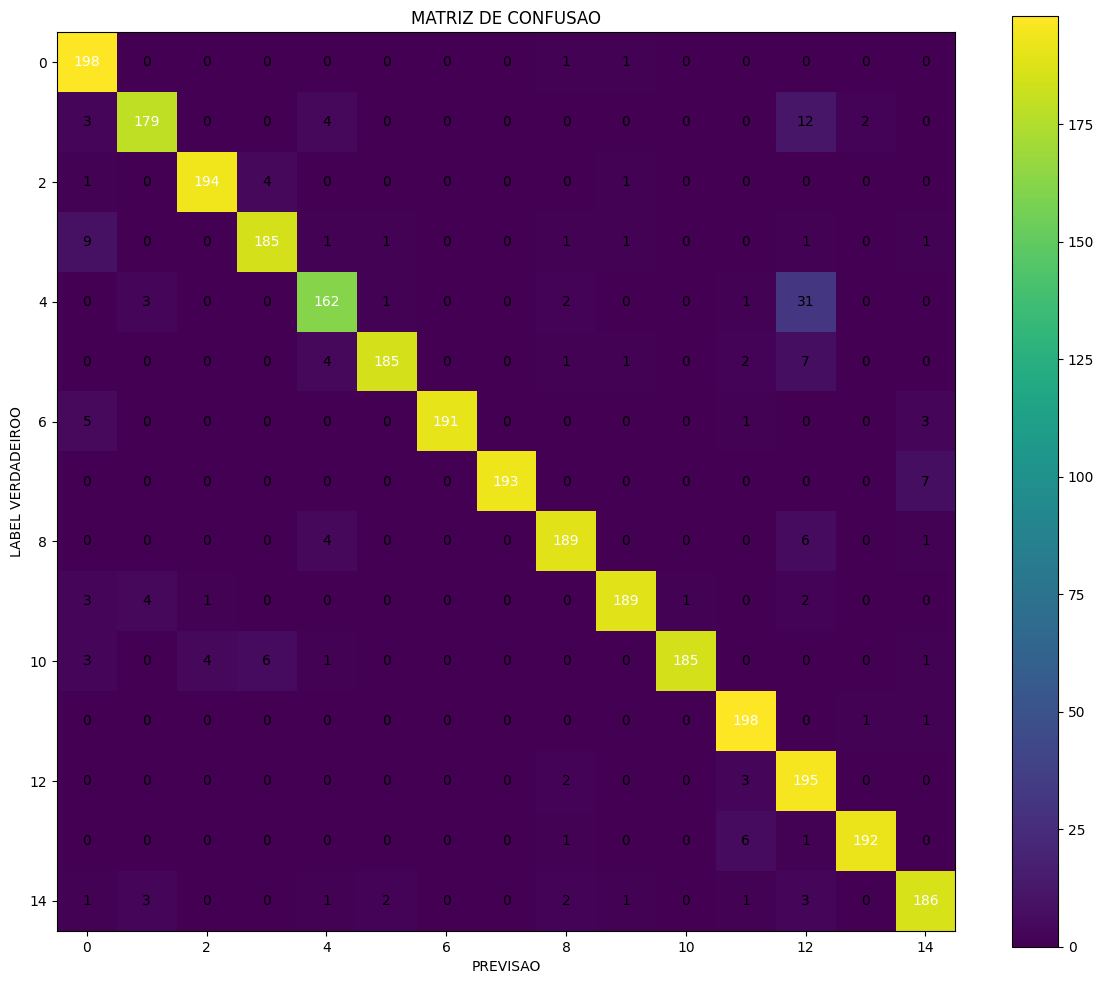

In [33]:
matriz_de_confusao = metodo_matriz_confusao(modelo, test_loader, 15)    #plota a matriz de confusao

atriz_de_confusao_pre = metodo_matriz_confusao(modelo_pre, test_loader, 15)    #plota a matriz de confusao

In [34]:
plt.figure(figsize=(12, 6))

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

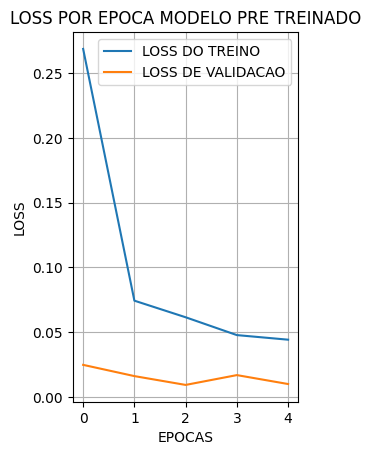

In [35]:
plt.subplot(1, 2, 1)    #cria um subplot 1 linha, 2 colunas, e ocupa a posicao 1
plt.plot(loss_treino_pre, label="LOSS DO TREINO")   #primeira curva
plt.plot(loss_validacao_pre, label="LOSS DE VALIDACAO") #segunda curva
plt.title("LOSS POR EPOCA MODELO PRE TREINADO") #titulo
plt.xlabel("EPOCAS")    #eixo x
plt.ylabel("LOSS")  #eixo y
plt.legend()
plt.grid(True)

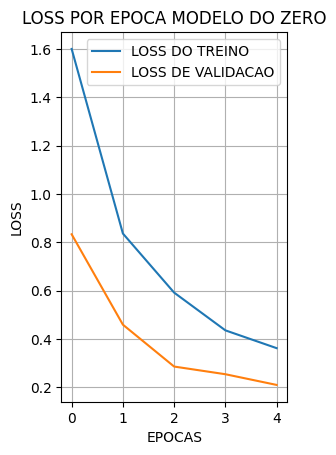

In [36]:
plt.subplot(1, 2, 1)    #cria um subplot 1 linha, 2 colunas, e ocupa a posicao 1
plt.plot(loss_treino, label="LOSS DO TREINO")   #primeira curva
plt.plot(loss_validacao, label="LOSS DE VALIDACAO") #segunda curva
plt.title("LOSS POR EPOCA MODELO DO ZERO") #titulo
plt.xlabel("EPOCAS")    #eixo x
plt.ylabel("LOSS")  #eixo y
plt.legend()
plt.grid(True)

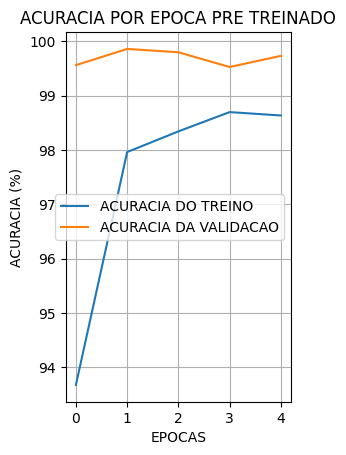

In [37]:
plt.subplot(1, 2, 2)    #cria um subplot 1 linha, 2 colunas, e ocupa a posicao 2
plt.plot(acuracia_treino_pre, label="ACURACIA DO TREINO")   #primeira curva
plt.plot(acuracia_validacao_pre, label="ACURACIA DA VALIDACAO") #segunda curva
plt.title("ACURACIA POR EPOCA PRE TREINADO") #titulo
plt.xlabel("EPOCAS")    #eixo x
plt.ylabel("ACURACIA (%)")  #eixo y
plt.legend()
plt.grid(True)

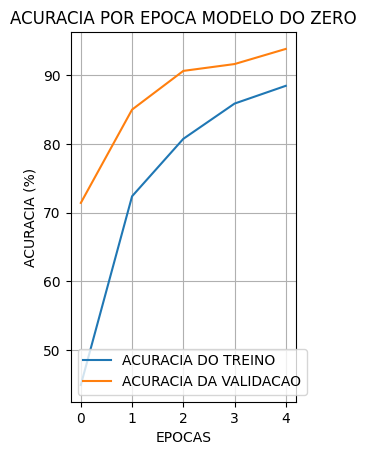

In [38]:
plt.subplot(1, 2, 2)    #cria um subplot 1 linha, 2 colunas, e ocupa a posicao 2
plt.plot(acuracia_treino, label="ACURACIA DO TREINO")   #primeira curva
plt.plot(acuracia_validacao, label="ACURACIA DA VALIDACAO") #segunda curva
plt.title("ACURACIA POR EPOCA MODELO DO ZERO") #titulo
plt.xlabel("EPOCAS")    #eixo x
plt.ylabel("ACURACIA (%)")  #eixo y
plt.legend()
plt.grid(True)

In [39]:
plt.tight_layout()
plt.show()

<Figure size 640x480 with 0 Axes>

In [40]:
print(f"loss treino:      {loss_treino}")
print(f"loss validacao:   {loss_validacao}")
print(f"loss teste:       {loss_teste}")

loss treino:      [np.float64(1.600218469781408), np.float64(0.8362848988728229), np.float64(0.5917757187825022), np.float64(0.43561429177710753), np.float64(0.3619449426338617)]
loss validacao:   [np.float64(0.8331636158709831), np.float64(0.45915398802211943), np.float64(0.2857946737996362), np.float64(0.25404299681131887), np.float64(0.20978042287652957)]
loss teste:       [np.float64(0.8219452608138957), np.float64(0.43938291881312713), np.float64(0.2694980466262774), np.float64(0.2363421589847), np.float64(0.2007249509866171)]


In [41]:
print(f"acuracia treino:     {acuracia_treino}")
print(f"acuracia validacao:  {acuracia_validacao}")
print(f"acuracia teste:      {acuracia_teste}")

acuracia treino:     [np.float64(44.882729211087415), np.float64(72.37695451314855), np.float64(80.74582444918266), np.float64(85.88530561478322), np.float64(88.4728144989339)]
acuracia validacao:  [np.float64(71.4095744680851), np.float64(85.00664893617021), np.float64(90.64716312056737), np.float64(91.64450354609929), np.float64(93.8497340425532)]
acuracia teste:      [np.float64(72.39583333333333), np.float64(85.9375), np.float64(91.21232269503545), np.float64(92.38696808510637), np.float64(94.0270390070922)]


In [42]:
print(f"F1 SCORE POR EPOCA:      {f1_score_por_epoca}")

F1 SCORE POR EPOCA:      [0.4472062681537533, 0.7236063455562859, 0.8076762485233366, 0.8589581055185975, 0.8847343321133351]


In [43]:
print("-------------------------------------------------------------")

-------------------------------------------------------------


In [44]:
print(f"loss treino PRE TREINADO:      {loss_treino_pre}")
print(f"loss validacao PRE TREINADO:   {loss_validacao_pre}")
print(f"loss teste PRE TREINADO:       {loss_teste_pre}")

loss treino PRE TREINADO:      [np.float64(0.268733459615961), np.float64(0.07432680809672208), np.float64(0.061511564268631504), np.float64(0.04774322390576151), np.float64(0.04419587505188711)]
loss validacao PRE TREINADO:   [np.float64(0.024757155296491817), np.float64(0.016078514684774378), np.float64(0.009265234649300258), np.float64(0.01684603104219237), np.float64(0.009955586364277283)]
loss teste PRE TREINADO:       [np.float64(0.024059829118839922), np.float64(0.020185201483322902), np.float64(0.013264689308422756), np.float64(0.0248030652031996), np.float64(0.012482376186489227)]


In [45]:
print(f"acuracia treino PRE TREINADO:     {acuracia_treino_pre}")
print(f"acuracia validacao PRE TREINADO:  {acuracia_validacao_pre}")
print(f"acuracia teste PRE TREINADO:      {acuracia_teste_pre}")

acuracia treino PRE TREINADO:     [np.float64(93.67686170212765), np.float64(97.96320921985816), np.float64(98.34441489361701), np.float64(98.69902482269502), np.float64(98.63696808510637)]
acuracia validacao PRE TREINADO:  [np.float64(99.56306990881458), np.float64(99.86227203647415), np.float64(99.80053191489363), np.float64(99.52982522796351), np.float64(99.7340425531915)]
acuracia teste PRE TREINADO:      [np.float64(99.76728723404256), np.float64(99.70079787234043), np.float64(99.7340425531915), np.float64(99.36835106382979), np.float64(99.70079787234043)]


In [46]:
print(f"F1 SCORE POR EPOCA PRE TREINADOO:      {f1_score_por_epoca_pre}")

F1 SCORE POR EPOCA PRE TREINADOO:      [0.9368755584867651, 0.9797990123561016, 0.9834034643902587, 0.9870647123276414, 0.986333086573806]
